# This is a CNN model on CIFAR10 dataset to classify images build using PyTorch

In [2]:
import torch
from torchvision import transforms
from torchvision import datasets
import numpy as np
from sklearn.model_selection import train_test_split

from torch.utils.data import SubsetRandomSampler, RandomSampler

from torch import nn, optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
if torch.cuda.is_available():
    device = "cuda"
print(device)

cuda


### Define transforms and load data

In [4]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(p =0.2),
                               transforms.RandomRotation(20),
                               transforms.RandomVerticalFlip(p = 0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                               ])
train_data = datasets.CIFAR10('data', train = True, transform = transform)
test_data = datasets.CIFAR10('data', train = False, transform = transform)

In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: data
    Transforms (if any): Compose(
                             RandomHorizontalFlip(p=0.2)
                             RandomRotation(degrees=(-20, 20), resample=False, expand=False)
                             RandomVerticalFlip(p=0.2)
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [7]:
batch_size = 20

valid_split = 0.2

len(train_data), len(train_data.train_labels), len(train_data.train_data)

(50000, 50000, 50000)

In [8]:
train_set, val_set = train_test_split(train_data,test_size = 0.2)

In [9]:
train_sampler = RandomSampler(train_set)
val_sampler = RandomSampler(val_set)
len(train_set), len(val_set)

(40000, 10000)

In [19]:
train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = 0)
val_loader = torch.utils.data.DataLoader(dataset = val_set, batch_size = batch_size, 
                                        sampler = val_sampler, num_workers = 0)

In [11]:
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 4,
                                          num_workers = 0
                                     )

In [47]:
len(test_loader)

2500

In [13]:
def implot(x):
#     print(type(x))
    x = x.numpy()
#     print(type(x))
    x = x*0.5 +0.5
    x = np.transpose(x, (1,2,0)) #unnormalize
    plt.imshow(x)
    plt.show()

In [10]:
image, label=next(iter(train_loader))
#for i,l in zip(image, label)
#implot(image)


In [11]:
print(label[0].numpy())
# implot(image[0])
image[0].numpy().shape, image[0].numpy().transpose().shape, image[0].numpy().transpose(1,2,0).shape

1


((3, 32, 32), (32, 32, 3), (32, 32, 3))

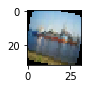

In [13]:
fig = plt.figure(figsize=(1,1))
plt.imshow((image[10]*0.5 +0.5).numpy().transpose(1,2,0))


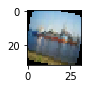

In [14]:
fig = plt.figure(figsize=(1,1))
implot(image[10])

In [126]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python  %%python2  %%

## Define convolutional network architecture

In [14]:
class Cnet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels= 8,kernel_size= 3, padding = 1)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels= 16,kernel_size= 3, padding = 1)
        self.pool2 = nn.MaxPool2d(kernel_size = 4, stride = 4)
        
        self.fc1 = nn.Linear(16*4*4, 64)
        self.fc2 = nn.Linear(64, 24)
        self.fc3 = nn.Linear(24,10)
        
        self.dropout = nn.Dropout(p = 0.25)
        
    def forward(self,x):
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*4*4)
        #x = self.dropout(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x
        
model = Cnet()
print(model)

model.cuda()
        

Cnet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=24, bias=True)
  (fc3): Linear(in_features=24, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


Cnet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=24, bias=True)
  (fc3): Linear(in_features=24, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)

In [14]:
class Cnet2(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels= 16,kernel_size= 3, padding = 1)
        
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels= 32,kernel_size= 3, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels= 64,kernel_size= 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,10)
        
        self.dropout = nn.Dropout(p = 0.25)
        
    def forward(self,x):
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 64*4*4)
        #x = self.dropout(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x
        
model = Cnet2()
print(model)

model.cuda()
        

Cnet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=24, bias=True)
  (fc3): Linear(in_features=24, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


Cnet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=24, bias=True)
  (fc3): Linear(in_features=24, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)

## Training the model

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [42]:
%%time
epochs = 30

running_train_loss = []
running_val_loss = []
min_val_loss = np.Inf

for epoch in range(1,epochs+1):
    model.train()
    train_loss = 0
    for image, label in train_loader:
        image, label = image.cuda(), label.cuda()
        
        
        optimizer.zero_grad()
        
       # print(image)
        
        train_output = model(image)
        loss_t = criterion(train_output, label)
        loss_t.backward()
        
        optimizer.step()
        
        train_loss += loss_t.item()
    
    running_train_loss.append(train_loss/len(train_loader))
    
    with torch.no_grad():
        loss_v = 0
        for image, label in val_loader:
            image, label = image.cuda(), label.cuda()
            model.eval()
            
            val_output = model(image)
            loss_v += criterion(val_output, label)
    
    running_val_loss.append(loss_v.item()/len(val_loader))  
    
    print("Epoch {} of {}....".format(epoch, epochs+1),
         "Training loss = {:.6f}...".format(train_loss/len(train_loader)),
         "Validation loss = {:.6f}...".format(loss_v/len(val_loader)),
         "Validation loss changed from {:.6f} to {:.6f}\n".format(min_val_loss,loss_v/len(val_loader)))
    
    min_val_loss = loss_v/len(val_loader)

Epoch 1 of 30...	 Training loss = 1.428104... Validation loss = 1.364434... Validation loss changed from inf to 1.364434

Epoch 2 of 30...	 Training loss = 1.426924... Validation loss = 1.341617... Validation loss changed from 1.364434 to 1.341617

Epoch 3 of 30...	 Training loss = 1.415600... Validation loss = 1.341002... Validation loss changed from 1.341617 to 1.341002

Epoch 4 of 30...	 Training loss = 1.411116... Validation loss = 1.338821... Validation loss changed from 1.341002 to 1.338821

Epoch 5 of 30...	 Training loss = 1.398208... Validation loss = 1.341385... Validation loss changed from 1.338821 to 1.341385

Epoch 6 of 30...	 Training loss = 1.399669... Validation loss = 1.318594... Validation loss changed from 1.341385 to 1.318594

Epoch 7 of 30...	 Training loss = 1.390121... Validation loss = 1.314368... Validation loss changed from 1.318594 to 1.314368

Epoch 8 of 30...	 Training loss = 1.386048... Validation loss = 1.345339... Validation loss changed from 1.314368 to

In [17]:
plt.plot(running_train_loss)
plt.plot(running_val_loss)
plt.legend()

NameError: name 'running_train_loss' is not defined

### Save model

In [38]:
torch.save(model.state_dict(),'Cnet1.pt')

In [16]:
model.load_state_dict(torch.load('Cnet1.pt'))

## Checking accuracy in test set

In [34]:
correct = 0
total = 0

test_loss = 0

with torch.no_grad():
    
    model.eval()

    i = 0

    for image, label in test_loader:
        i += 1
        image, label = image.cuda(), label.cuda()

        test_output = model(image)

        loss_t = criterion(test_output, label)
        
        test_loss += loss_t.item()
        
        _,pred = torch.max(test_output.data, 1)
        
        total += label.size(0)
        correct += (pred == label).sum().item()
        
print("Accuracy on test set = {}\nTest loss = {}".format(correct/total ,test_loss/len(test_loader)))        

#         print(test_output)

Accuracy on test set = 0.5163
Test loss = 1.3474479886651038


In [48]:
class_correct = [0. for i in range(10)]
class_total = [0. for i in range(10)]
test_loss = 0

# total = 

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        test_output = model(images)
        test_loss += criterion(test_output, labels)
        _,pred = torch.max(test_output,1)
        
        for i in range(4):
            label = labels[i]
            if pred[i] == label:
                class_correct[label] += 1
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(classes[i], 100*class_correct[i]/class_total[i]))

total_correct = np.sum(class_correct)
total = np.sum(class_total)
print("\nTotal Accuracy = {}".format(100* total_correct/total))  

print("total correct {} out of {}".format(total_correct,total))
            

Accuracy of plane: 60.7%
Accuracy of car: 69.8%
Accuracy of bird: 33.3%
Accuracy of cat: 43.5%
Accuracy of deer: 50.8%
Accuracy of dog: 25.3%
Accuracy of frog: 64.4%
Accuracy of horse: 52.5%
Accuracy of ship: 62.5%
Accuracy of truck: 48.5%

Total Accuracy = 51.13
total correct 5113.0 out of 10000.0


In [43]:
with torch.no_grad():
    for image, label in test_loader:
        image, label = image.cuda(), label.cuda()
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == label).squeeze()
        for i in range(4):
            l = label[i]
            class_correct[l] += c[i].item()
            class_total[l] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 70 %
Accuracy of  bird : 33 %
Accuracy of   cat : 42 %
Accuracy of  deer : 50 %
Accuracy of   dog : 26 %
Accuracy of  frog : 67 %
Accuracy of horse : 52 %
Accuracy of  ship : 59 %
Accuracy of truck : 49 %


In [42]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
#     correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(4):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.341166

Test Accuracy of plane: 59% (599/1000)
Test Accuracy of   car: 71% (715/1000)
Test Accuracy of  bird: 33% (338/1000)
Test Accuracy of   cat: 42% (422/1000)
Test Accuracy of  deer: 50% (504/1000)
Test Accuracy of   dog: 25% (252/1000)
Test Accuracy of  frog: 69% (698/1000)
Test Accuracy of horse: 53% (538/1000)
Test Accuracy of  ship: 60% (604/1000)
Test Accuracy of truck: 50% (508/1000)

Test Accuracy (Overall): 51% (5178/10000)


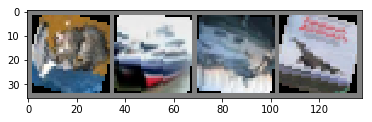

GroundTruth:    cat  ship  ship plane


In [63]:
import torchvision
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
#plt.figure(figsize = (4,4))
implot(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [67]:
labels, classes[1]

(tensor([3, 8, 8, 0]), 'car')

In [20]:
len(test_loader)

2500

In [72]:
t = model(images.cuda())

In [79]:
t.data

tensor([[ -1.0259,  -1.7916,  -1.5066,  -1.3548,  -0.1463,  -1.0275,  -3.7739,
           1.2907,  -2.5774,   0.0498],
        [  2.0779,   4.2399,  -4.9108,  -9.1863,  -7.9942, -10.3765,  -9.0755,
          -9.5393,   3.7997,   2.4146],
        [  0.5304,   0.3058,  -0.9622,  -1.8464,  -1.4826,  -2.7507,  -1.8644,
          -2.8555,   1.2413,   0.0579],
        [  1.4376,  -0.8118,  -0.5838,  -2.6466,  -1.7607,  -3.2404,  -3.8107,
          -2.8049,   1.0942,  -0.4986]], device='cuda:0')

In [78]:
torch.max(t.data,1)

(tensor([ 2.0779,  4.2399, -0.5838, -1.3548, -0.1463, -1.0275, -1.8644,  1.2907,
          3.7997,  2.4146], device='cuda:0'),
 tensor([1, 1, 3, 0, 0, 0, 2, 0, 1, 1], device='cuda:0'))